# Chlorophyll Model and Observations and Ice Fraction.

In [3]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
#import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [4]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

# input file

In [5]:
#### print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

 GNG595


What year? (year)


 20yrclim


In [6]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [9]:
### 20 year climatology GNG595 from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim/*', recursive=True),
                      key=numericalSort)

In [10]:
new = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

In [12]:
obsfiles = sorted(glob.glob('/glade/work/jluo/obs/SeaWiFS/climatology_regridded/'+'*L3m_MC_CHL_chl_ocx_gx1v6.nc', recursive=True),
                      key=numericalSort)
obs = xr.open_mfdataset(obsfiles,combine='by_coords')

	NC4_open: path /glade/work/jluo/obs/SeaWiFS/climatology_regridded/01_S19980012010031.L3m_MC_CHL_chl_ocx_gx1v6.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/work/jluo/obs/SeaWiFS/climatology_regridded/01_S19980012010031.L3m_MC_CHL_chl_ocx_gx1v6.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset nlat
			found dataset nlon
			found dataset time
			found dataset chl_ocx
			found dataset TLONG
			found dataset TLAT
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0xd0000 ext_ncid 0xd0000
		FILE - path: /glade/work/jluo/obs/SeaWiFS/climatology_regridded/01_S19980012010031.L3m_MC_CHL_chl_ocx_gx1v6.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 6 natts: 0
		 DIMENSION - dimid: 0 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 1 name: nlon len: 320 unlimited: 0
		 DIMENSION - dimid: 2 name: time len: 1 u

In [13]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [14]:
chla_new = np.nansum(np.stack([new.ppChl, new.mp1Chl, new.diazChl, new.diat1Chl, new.mp2Chl, new.diat2Chl, new.mp3Chl, new.diat3Chl, new.mp4Chl]), axis =0)
chla_new[chla_new<=0]=np.nan

Chla_vertical_integrated = np.nansum(chla_new[:,0:5,:,:], axis=1)*10/50 

## Seasonality in both SPECTRA and SeaWIFS throughout the Arctic

In [15]:
obsfiles_regrid = sorted(glob.glob('/glade/scratch/gabyn/SeaWiFS/monthly_climatology_reggrid/regrid_chl_ocx_SeaWiFS.*.nc', recursive=True),
                      key=numericalSort)
obss = xr.open_mfdataset(obsfiles_regrid,concat_dim='time',combine='nested')

OSError: no files to open

In [ ]:
diat1_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat1Chl.*.nc', recursive=True))
diat1_ds = xr.open_mfdataset(diat1_inds,combine='by_coords')

diat2_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat2Chl.*.nc', recursive=True))
diat2_ds = xr.open_mfdataset(diat2_inds,combine='by_coords')

diat3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat3Chl.*.nc', recursive=True))
diat3_ds = xr.open_mfdataset(diat3_inds,combine='by_coords')

mp1_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp1Chl.*.nc', recursive=True))
mp1_ds = xr.open_mfdataset(mp1_inds,combine='by_coords')

mp2_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp2Chl.*.nc', recursive=True))
mp2_ds = xr.open_mfdataset(mp2_inds,combine='by_coords')

mp3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp3Chl.*.nc', recursive=True))
mp3_ds = xr.open_mfdataset(mp3_inds,combine='by_coords')

mp4_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp4Chl.*.nc', recursive=True))
mp4_ds = xr.open_mfdataset(mp4_inds,combine='by_coords')

pp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_ppChl.*.nc', recursive=True))
pp_ds = xr.open_mfdataset(pp_inds,combine='by_coords')

diaz_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diazChl.*.nc', recursive=True))
diaz_ds = xr.open_mfdataset(diaz_inds,combine='by_coords')

PAR_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_PAR_avg.*.nc', recursive=True))
PAR_ds = xr.open_mfdataset(PAR_inds,combine='by_coords')

ice_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_ECOSYS_IFRAC.*.nc', recursive=True))
ice_ds = xr.open_mfdataset(ice_inds,combine='by_coords')

In [ ]:
phytoChl = np.stack([pp_ds.ppChl, mp1_ds.mp1Chl, diaz_ds.diazChl, 
                               diat1_ds.diat1Chl, mp2_ds.mp2Chl, diat2_ds.diat2Chl, 
                               mp3_ds.mp3Chl, diat3_ds.diat3Chl, mp4_ds.mp4Chl])


In [ ]:
phytoChl.shape

In [29]:
phytoChl_50m = np.nansum(phytoChl[:,:,0:5,:,:], axis =(0,2))*10/50 
phytoChl_surface = np.nansum(phytoChl[:,:,0,:,:], axis =0) 

#### Create an array where it is 1 if the ice fraction is more than 80 percent in a month, and zero if it is less than that on that on a evrage for every region of the Arctic 

ice_frac_80 = np.array(ice_ds.ECOSYS_IFRAC)
## This is creating it for the whole Arctic Ocean. 
for i in range(149,180):
    for j in range(360):
        for l in range(12):
            if ice_ds.ECOSYS_IFRAC[l,i,j].values>0.79:
                ice_frac_80[l,i,j] = 1
            else: 
                ice_frac_80[l,i,j] = 0
                
## Save the data array 
np.save("/glade/scratch/gabyn/Sfm_data/ice_frac_AO.npy", ice_frac_80)

ice_frac_80 = np.load("/glade/scratch/gabyn/Sfm_data/ice_frac_AO.npy")

In [30]:
# Model ice for every region 
ice_ao = np.nanmean(ice_ds.ECOSYS_IFRAC[:,170:180,:], axis=(1,2))
ice_cs = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,0:25], axis = (1,2))
ice_bs = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,25:55], axis = (1,2))
ice_ca = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,55:80], axis = (1,2))
ice_bb = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,80:135], axis = (1,2))
ice_ess = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,325:360], axis = (1,2))
ice_ls = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,270:325], axis = (1,2))
ice_ns = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,155:205], axis = (1,2))
ice_bts =np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,205:233], axis = (1,2))
ice_ks = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,233:270], axis = (1,2))


# Modeling the PAR average 
PAR_ao = np.nanmean(PAR_ds.PAR_avg[:,0,170:180,:], axis=(1,2))
PAR_cs = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,0:25], axis = (1,2))
PAR_bs = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,25:55], axis = (1,2))
PAR_ca = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,55:80], axis = (1,2))
PAR_bb = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,80:135], axis = (1,2))
PAR_ess = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,325:360], axis = (1,2))
PAR_ls = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,270:325], axis = (1,2))
PAR_ns = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,155:205], axis = (1,2))
PAR_bts =np.nanmean(PAR_ds.PAR_avg[:,0,149:170,205:233], axis = (1,2))
PAR_ks = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,233:270], axis = (1,2))

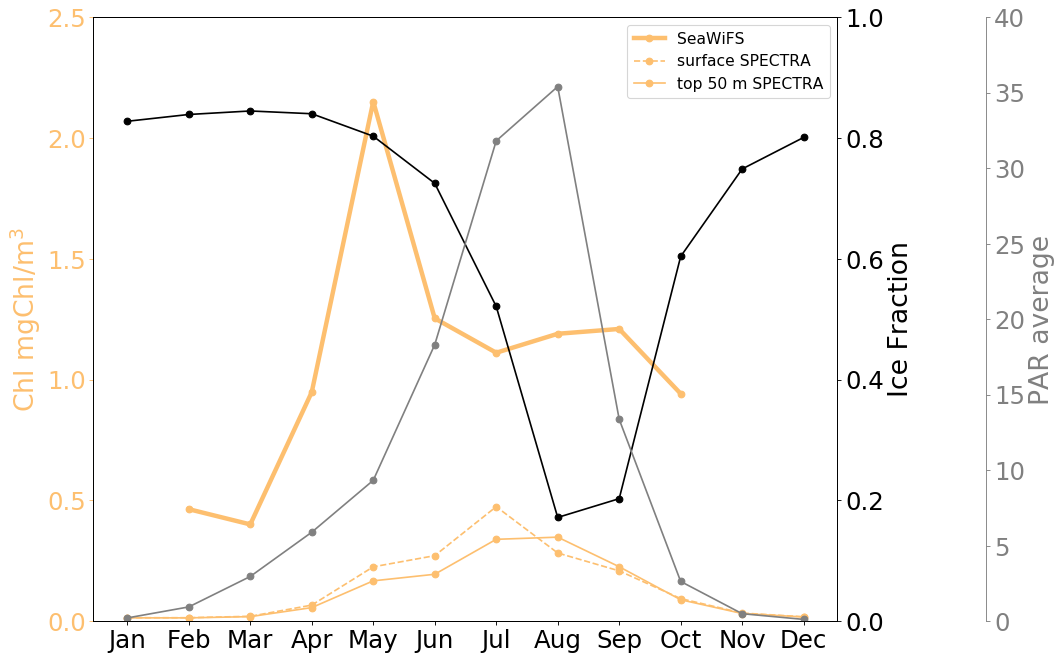

In [31]:
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:179, :],axis=(1,2)),'-o', color='k',label='Ice-Fraction')
ax3.plot(months, np.nanmean(PAR_ds.PAR_avg[:,0,149:179, :],axis=(1,2)),'-o', color='gray',label='PAR Average')
ax.plot(months,np.nanmean(obss.chl_ocx[:,149:179, :],axis=(1,2)), '-o', color=cmap(3),linewidth=4,label='SeaWiFS')
ax.plot(months,np.nanmean(phytoChl_surface[:,149:179, :], axis=(1,2)), '--o', color=cmap(3),label='surface SPECTRA')
ax.plot(months,np.nanmean(phytoChl_50m[:,149:179, :], axis=(1,2)), '-o', color=cmap(3),label='top 50 m SPECTRA')
ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,40)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(3))  
ax.spines['left'].set_color(cmap(3)); ax.tick_params(axis='y', colors=cmap(3))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_global_motnhly_Ice_Fraction_'+year+'year.png', dpi=600, bbox_inches='tight')

In [32]:
# Model Chlorophyll for every region (surface)
model_ao = np.nanmean(phytoChl_surface[:,170:180,:], axis=(1,2))
model_cs = np.nanmean(phytoChl_surface[:,149:170,0:25], axis = (1,2))
model_bs = np.nanmean(phytoChl_surface[:,149:170,25:55], axis = (1,2))
model_ca = np.nanmean(phytoChl_surface[:,149:170,55:80], axis = (1,2))
model_bb = np.nanmean(phytoChl_surface[:,149:170,80:135], axis = (1,2))
model_ess = np.nanmean(phytoChl_surface[:,149:170,325:360], axis = (1,2))
model_ls = np.nanmean(phytoChl_surface[:,149:170,270:325], axis = (1,2))
model_ns = np.nanmean(phytoChl_surface[:,149:170,155:205], axis = (1,2))
model_bts =np.nanmean(phytoChl_surface[:,149:170,205:233], axis = (1,2))
model_ks = np.nanmean(phytoChl_surface[:,149:170,233:270], axis = (1,2))

# Top 50 meters
model_ao_50m = np.nanmean(phytoChl_50m[:,170:180,:], axis=(1,2))
model_cs_50m = np.nanmean(phytoChl_50m[:,149:170,0:25], axis = (1,2))
model_bs_50m = np.nanmean(phytoChl_50m[:,149:170,25:55], axis = (1,2))
model_ca_50m = np.nanmean(phytoChl_50m[:,149:170,55:80], axis = (1,2))
model_bb_50m = np.nanmean(phytoChl_50m[:,149:170,80:135], axis = (1,2))
model_ess_50m = np.nanmean(phytoChl_50m[:,149:170,325:360], axis = (1,2))
model_ls_50m = np.nanmean(phytoChl_50m[:,149:170,270:325], axis = (1,2))
model_ns_50m = np.nanmean(phytoChl_50m[:,149:170,155:205], axis = (1,2))
model_bts_50m =np.nanmean(phytoChl_50m[:,149:170,205:233], axis = (1,2))
model_ks_50m = np.nanmean(phytoChl_50m[:,149:170,233:270], axis = (1,2))

# Observed Chlorophyll for every region. 

obs_ao = np.nanmean(obss.chl_ocx[:,170:180,:], axis=(1,2))
obs_cs = np.nanmean(obss.chl_ocx[:,149:170,0:25], axis = (1,2))
obs_bs = np.nanmean(obss.chl_ocx[:,149:170,25:55], axis = (1,2))
obs_ca = np.nanmean(obss.chl_ocx[:,149:170,55:80], axis = (1,2))
obs_bb = np.nanmean(obss.chl_ocx[:,149:170,80:135], axis = (1,2))
obs_ess = np.nanmean(obss.chl_ocx[:,149:170,325:360], axis = (1,2))
obs_ls = np.nanmean(obss.chl_ocx[:,149:170,270:325], axis = (1,2))
obs_ns = np.nanmean(obss.chl_ocx[:,149:170,155:205], axis = (1,2))
obs_bts =np.nanmean(obss.chl_ocx[:,149:170,205:233], axis = (1,2))
obs_ks = np.nanmean(obss.chl_ocx[:,149:170,233:270], axis = (1,2))

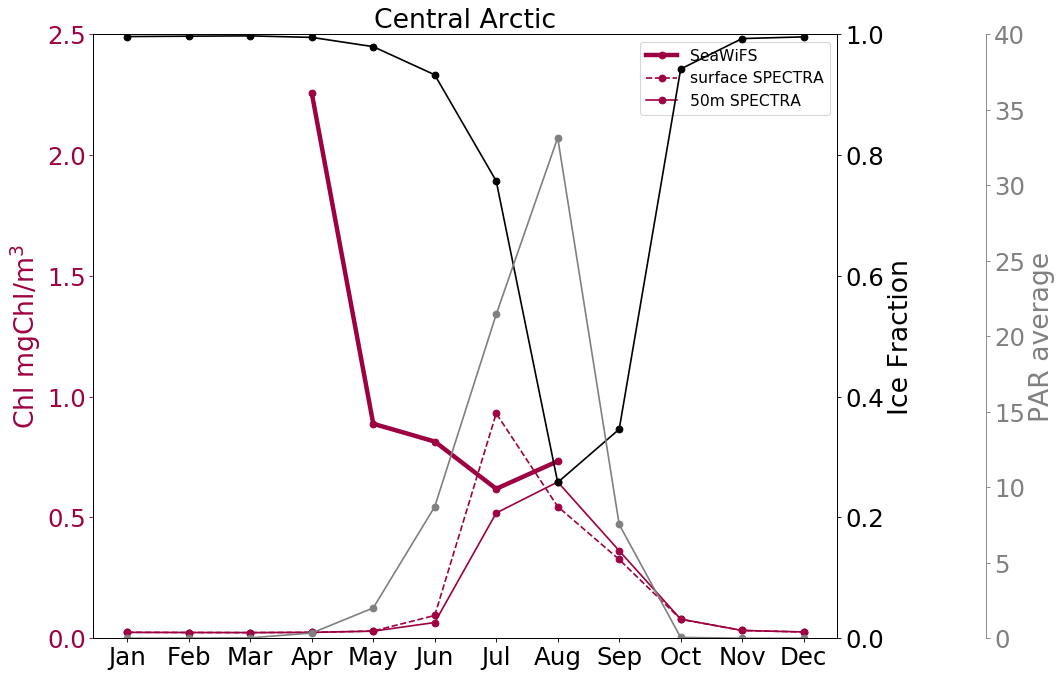

In [33]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ao, '-o', color=cmap(0),linewidth=4,label='SeaWiFS')
ax.plot(months,model_ao, '--o', color=cmap(0),label='surface SPECTRA')
ax.plot(months,model_ao_50m, '-o', color=cmap(0),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Central Arctic', fontsize=24)

ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ao,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ao,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,40)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(0))  
ax.spines['left'].set_color(cmap(0)); ax.tick_params(axis='y', colors=cmap(0))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_central_Arctic_Ice_Fraction_'+year+'year.png', dpi=600, bbox_inches='tight')

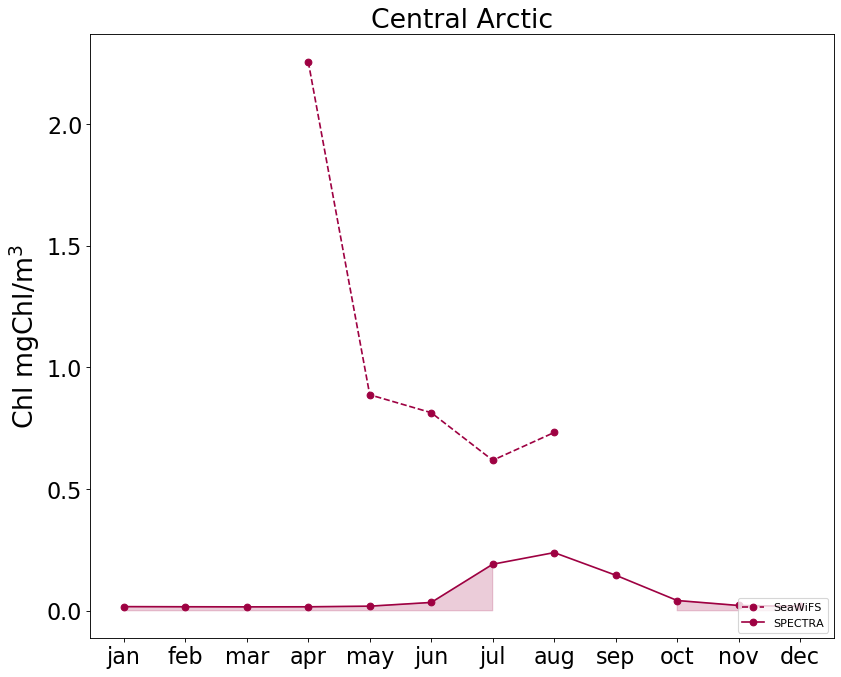

In [28]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ao, '--o', color=cmap(0),label='SeaWiFS')
ax.plot(months,model_ao, '-o', color=cmap(0),label='SPECTRA')
ax.fill_between(months, model_ao, where=np.nanmean(ice_ds.ECOSYS_IFRAC[:,170:180,:],axis=(1,2)) > 0.6, color=cmap(0), alpha=.2)

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Central Arctic', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_central_Arctic_Ice_06_'+year+'year.png', dpi=600, bbox_inches='tight')

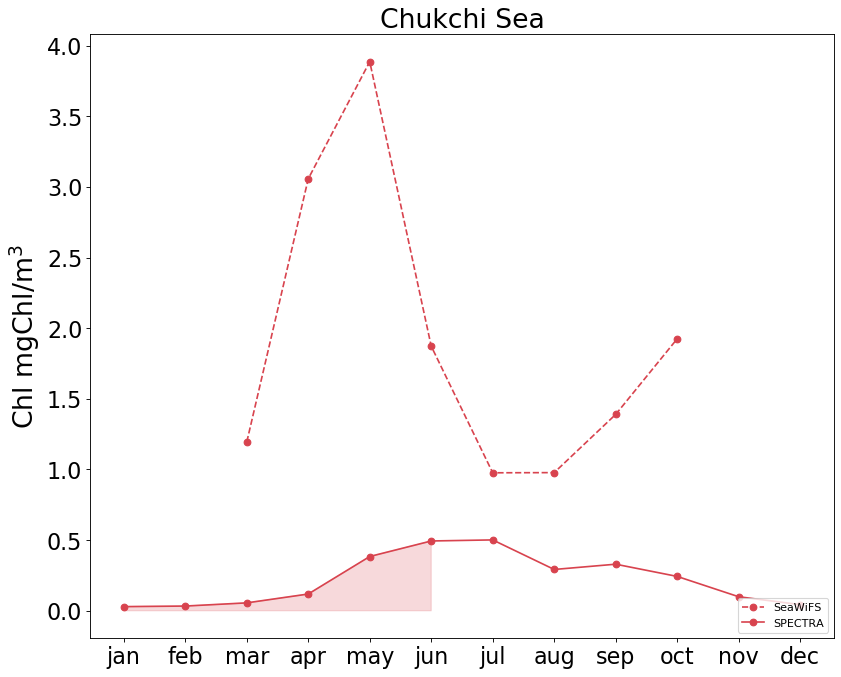

In [34]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_cs, '--o',color=cmap(1),label='SeaWiFS')
ax.plot(months,model_cs, '-o',color=cmap(1),label='SPECTRA')
ax.fill_between(months, model_cs, where=np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,0:25],axis=(1,2)) > 0.6, color=cmap(1), alpha=.2)



ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Chukchi Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Chukchi_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

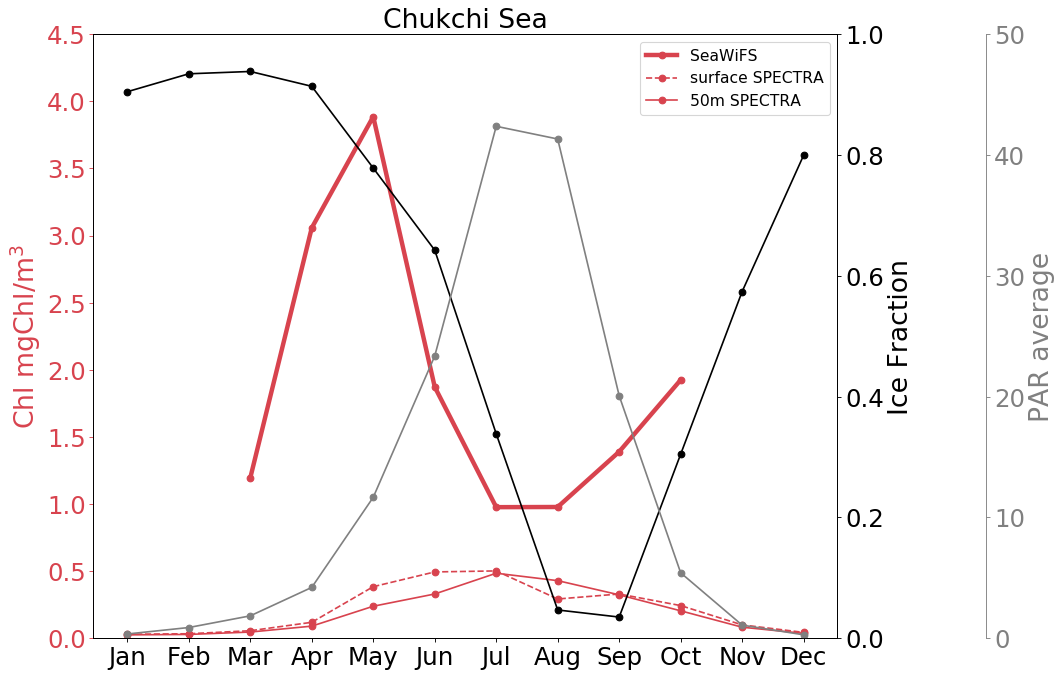

In [35]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_cs, '-o', color=cmap(1),linewidth = 4, label='SeaWiFS')
ax.plot(months,model_cs, '--o', color=cmap(1),label='surface SPECTRA')
ax.plot(months,model_cs_50m, '-o', color=cmap(1),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Chukchi Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_cs,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_cs,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,4.5); ax2.set_ylim(0,1); ax3.set_ylim(0,50)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5, 3.0,3.5,4.0,4.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(1))  
ax.spines['left'].set_color(cmap(1)); ax.tick_params(axis='y', colors=cmap(1))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Chukchi_Sea_Ice_Fraction_'+year+'year.png', dpi=600, bbox_inches='tight')

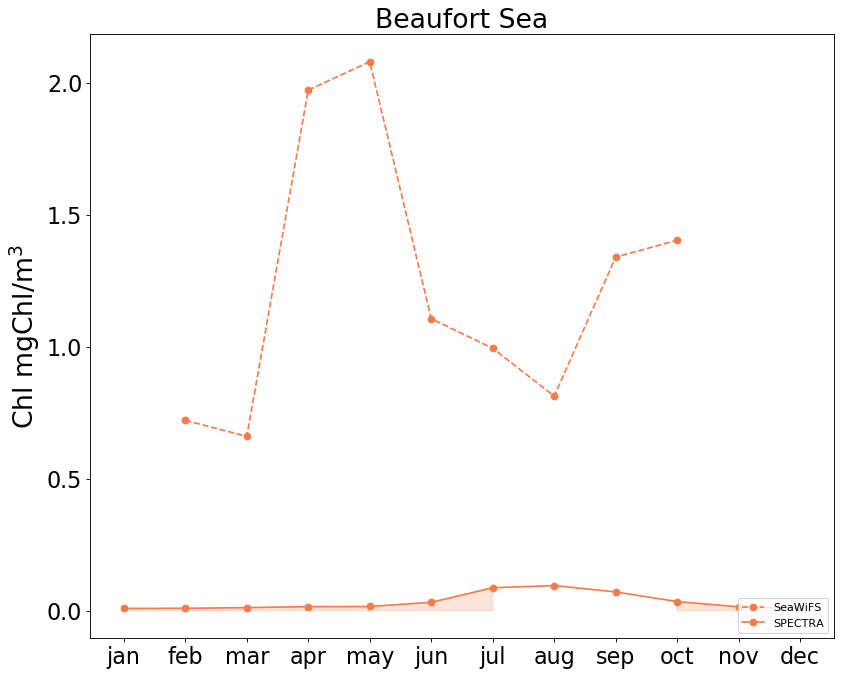

In [32]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bs, '--o', color=cmap(2),label='SeaWiFS')
ax.plot(months,model_bs, '-o', color=cmap(2),label='SPECTRA')
ax.fill_between(months, model_bs, where=np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,25:55],axis=(1,2)) > 0.6, color=cmap(2), alpha=.2)


ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Beaufort Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Beaufort_Sea_Ice_06_'+year+'year.png', dpi=600, bbox_inches='tight')

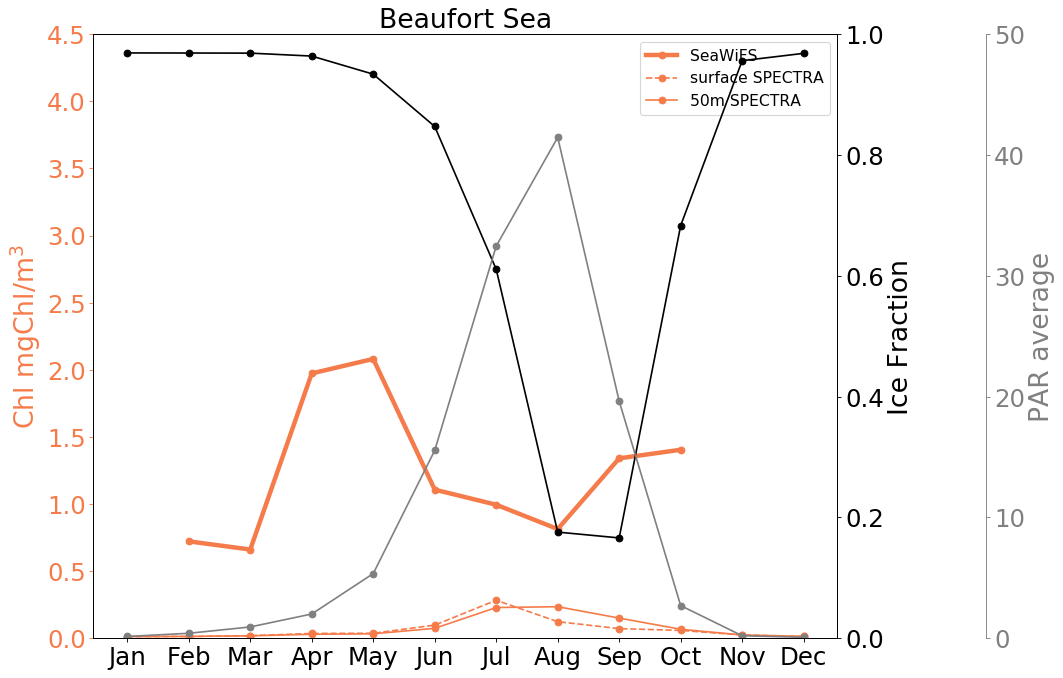

In [36]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bs, '-o', color=cmap(2),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_bs, '--o', color=cmap(2),label='surface SPECTRA')
ax.plot(months,model_bs_50m, '-o', color=cmap(2),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Beaufort Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bs,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bs,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,4.5); ax2.set_ylim(0,1); ax3.set_ylim(0,50)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5, 3.0,3.5,4.0,4.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(2))  
ax.spines['left'].set_color(cmap(2)); ax.tick_params(axis='y', colors=cmap(2))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Beaufort_Sea_Ice_Fraction_'+year+'year.png', dpi=600, bbox_inches='tight')

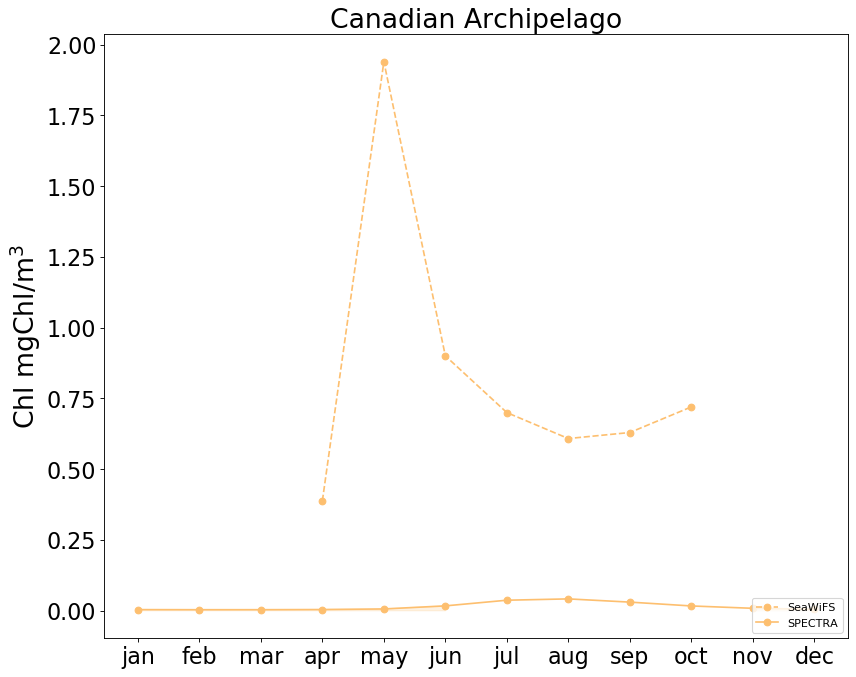

In [34]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ca, '--o', color=cmap(3),label='SeaWiFS')
ax.plot(months,model_ca, '-o', color=cmap(3),label='SPECTRA')
ax.fill_between(months, model_ca, where=np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,55:110],axis=(1,2)) > 0.6, color=cmap(3), alpha=.2)

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Canadian Archipelago', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Canadian_Archipelago_Ice_06_'+year+'year.png', dpi=600, bbox_inches='tight')

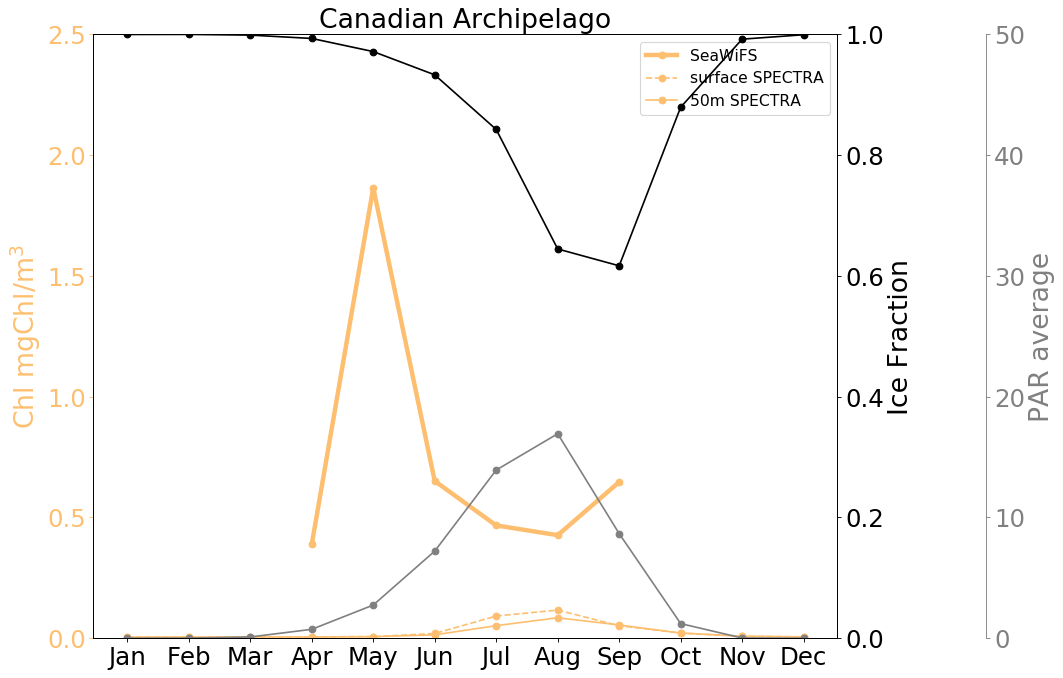

In [37]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ca, '-o', color=cmap(3),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_ca, '--o', color=cmap(3),label='surface SPECTRA')
ax.plot(months,model_ca_50m, '-o', color=cmap(3),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Canadian Archipelago', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ca,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ca,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,50)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(3))  
ax.spines['left'].set_color(cmap(3)); ax.tick_params(axis='y', colors=cmap(3))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Canadian_Archipelago_Ice_Fraction_'+year+'year.png', dpi=600, bbox_inches='tight')

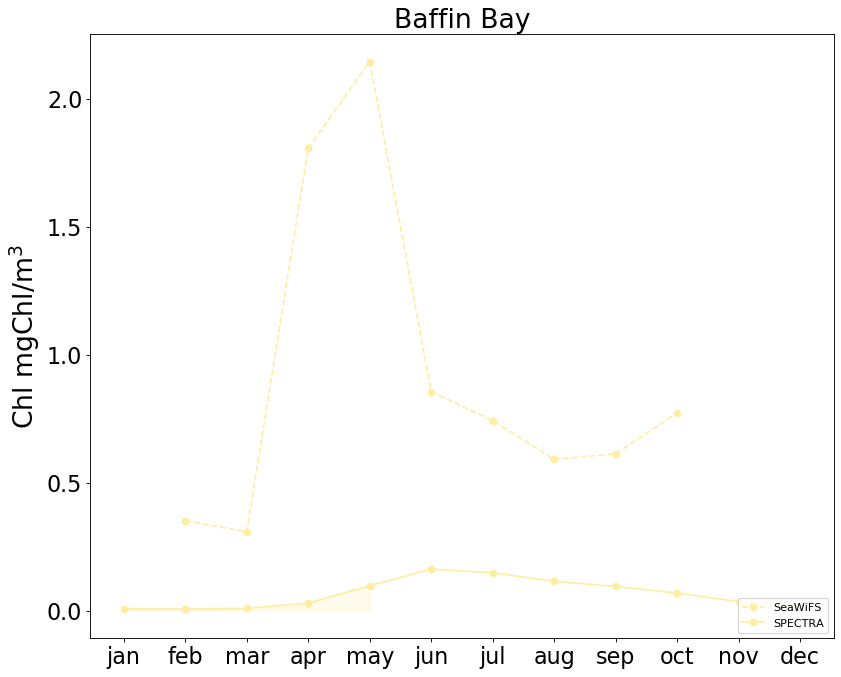

In [36]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bb, '--o', color=cmap(4),label='SeaWiFS')
ax.plot(months,model_bb, '-o', color=cmap(4),label='SPECTRA')
ax.fill_between(months, model_bb, where=np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,110:135],axis=(1,2)) > 0.6, color=cmap(4), alpha=.2)


ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Baffin Bay', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Baffin_Bay_Ice_06_'+year+'year.png', dpi=600, bbox_inches='tight')

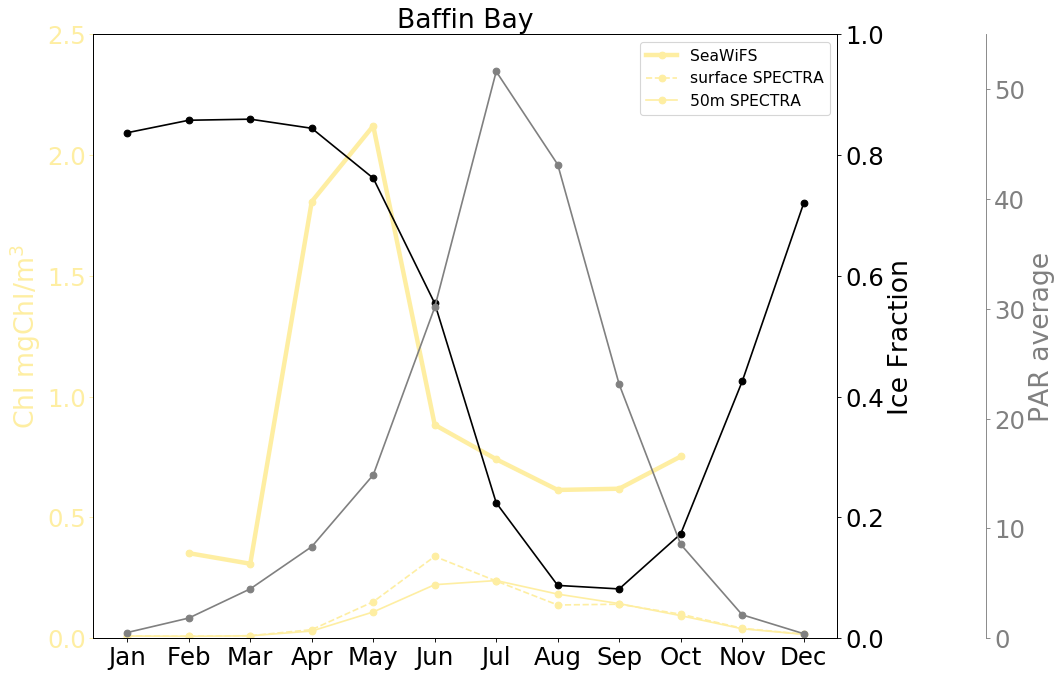

In [38]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bb, '-o', color=cmap(4),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_bb, '--o', color=cmap(4),label='surface SPECTRA')
ax.plot(months,model_bb_50m, '-o', color=cmap(4),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Baffin Bay', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bb,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bb,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(4))  
ax.spines['left'].set_color(cmap(4)); ax.tick_params(axis='y', colors=cmap(4))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Baffin_Bay_Ice_Fraction_'+year+'year.png', dpi=600, bbox_inches='tight')

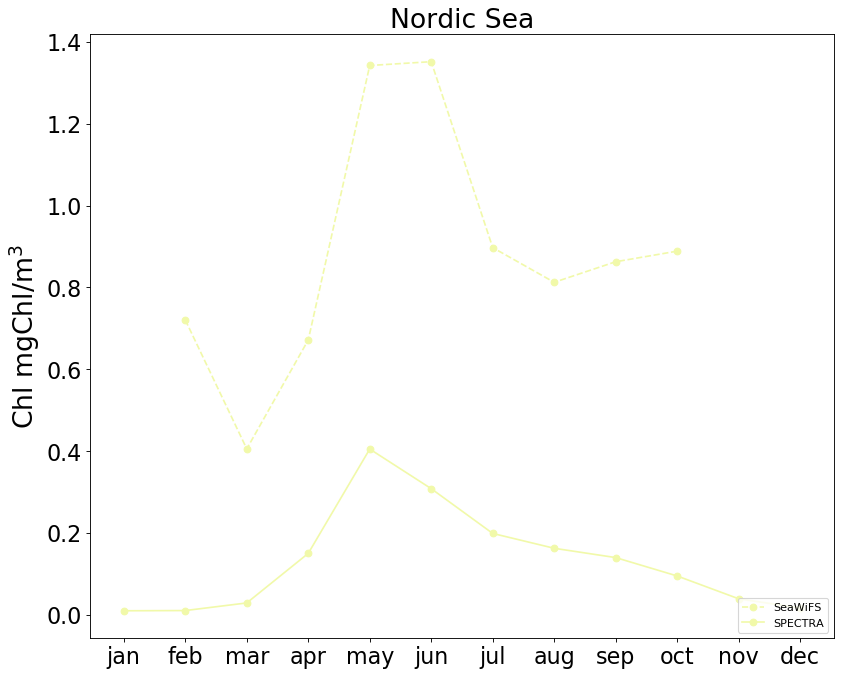

In [38]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ns, '--o', color=cmap(5),label='SeaWiFS')
ax.plot(months,model_ns, '-o', color=cmap(5),label='SPECTRA')
ax.fill_between(months, model_ns, where=np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,155:205],axis=(1,2)) > 0.6, color=cmap(5), alpha=.2)


ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Nordic Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Nordic_Sea_Ice_06_'+year+'year.png', dpi=600, bbox_inches='tight')

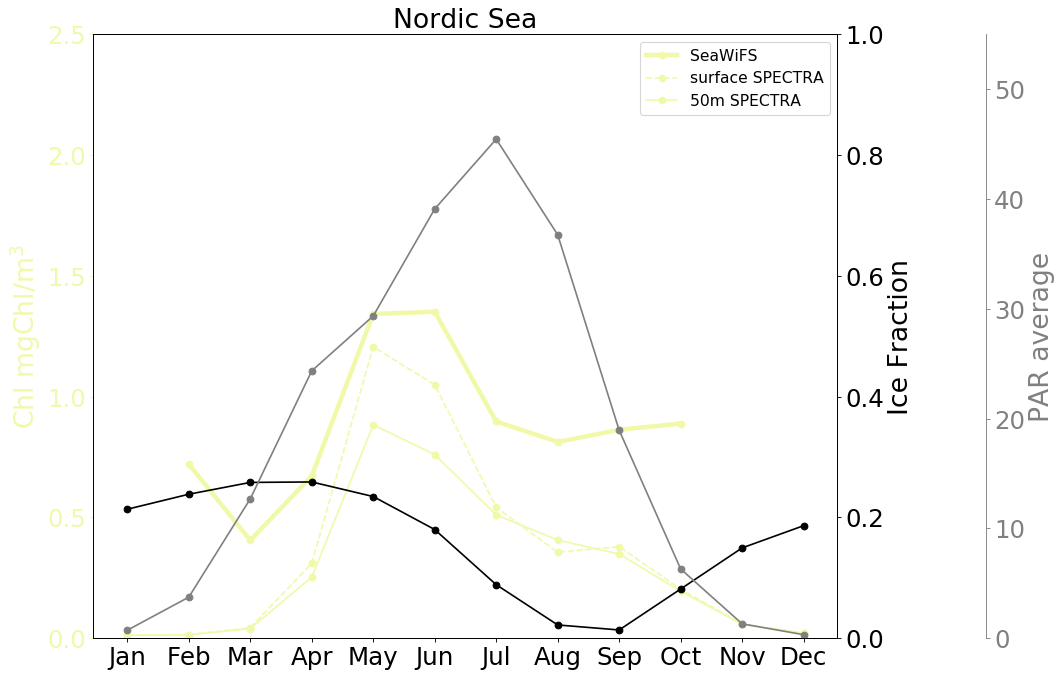

In [39]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ns, '-o', color=cmap(5),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_ns, '--o', color=cmap(5),label='surface SPECTRA')
ax.plot(months,model_ns_50m, '-o', color=cmap(5),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Nordic Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ns,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ns,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(5))  
ax.spines['left'].set_color(cmap(5)); ax.tick_params(axis='y', colors=cmap(5))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Nordic_Sea_Ice_Fraction_'+year+'year.png', dpi=600, bbox_inches='tight')

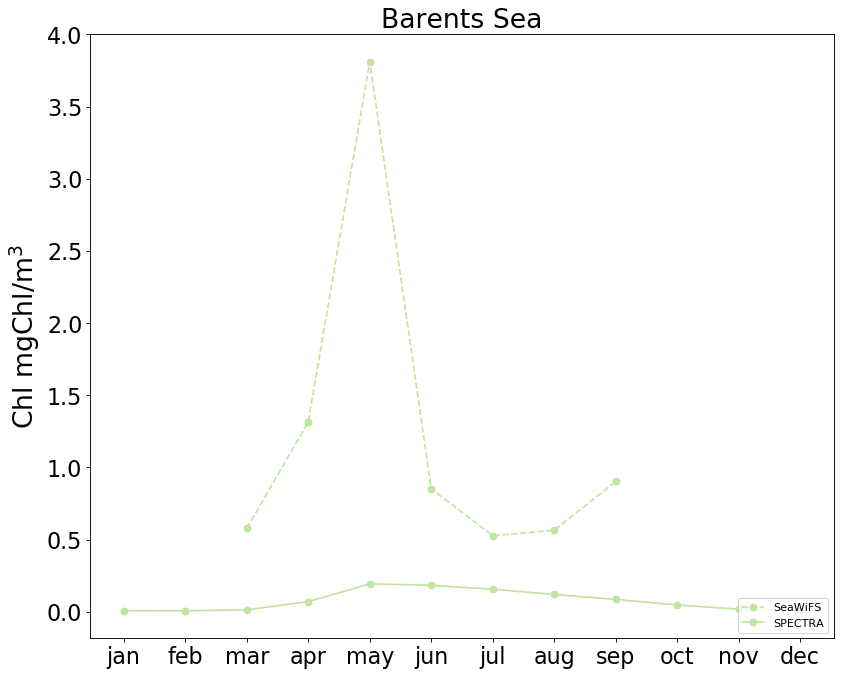

In [40]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bts, '--o',color=cmap(6),label='SeaWiFS')
ax.plot(months,model_bts, '-o',color=cmap(6),label='SPECTRA')
ax.fill_between(months, model_bts, where=np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,205:233],axis=(1,2)) > 0.6, color=cmap(6), alpha=.2)

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Barents Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Barents_Sea_Ice_06_'+year+'year.png', dpi=600, bbox_inches='tight')

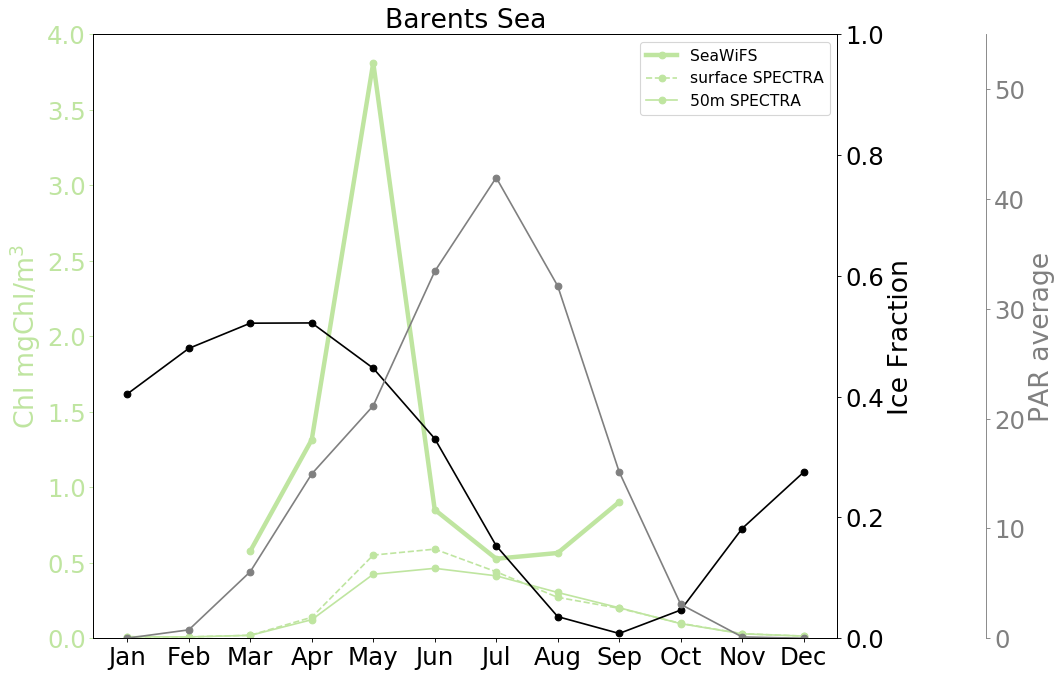

In [40]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bts, '-o', color=cmap(6),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_bts, '--o', color=cmap(6),label='surface SPECTRA')
ax.plot(months,model_bts_50m, '-o', color=cmap(6),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Barents Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bts,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bts,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,4.0); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(6))  
ax.spines['left'].set_color(cmap(6)); ax.tick_params(axis='y', colors=cmap(6))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Barents_Sea_Ice_Fraction_'+year+'year.png', dpi=600, bbox_inches='tight')

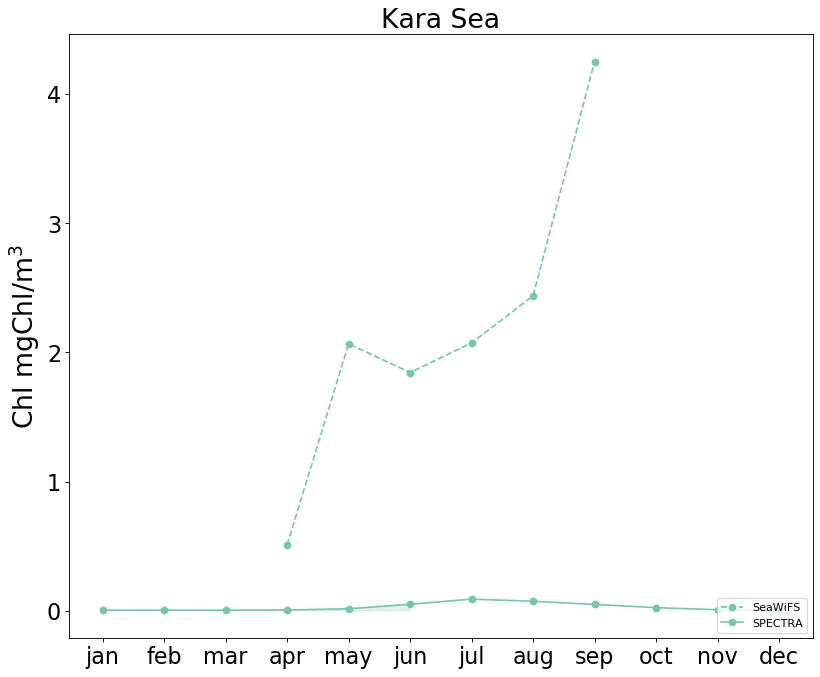

In [42]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ks, '--o', color=cmap(7),label='SeaWiFS')
ax.plot(months,model_ks, '-o', color=cmap(7),label='SPECTRA')
ax.fill_between(months, model_ks, where=np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,233:270],axis=(1,2)) > 0.6, color=cmap(7), alpha=.2)

ax.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Kara Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Kara_Sea_Ice_06_'+year+'year.png', dpi=600, bbox_inches='tight')

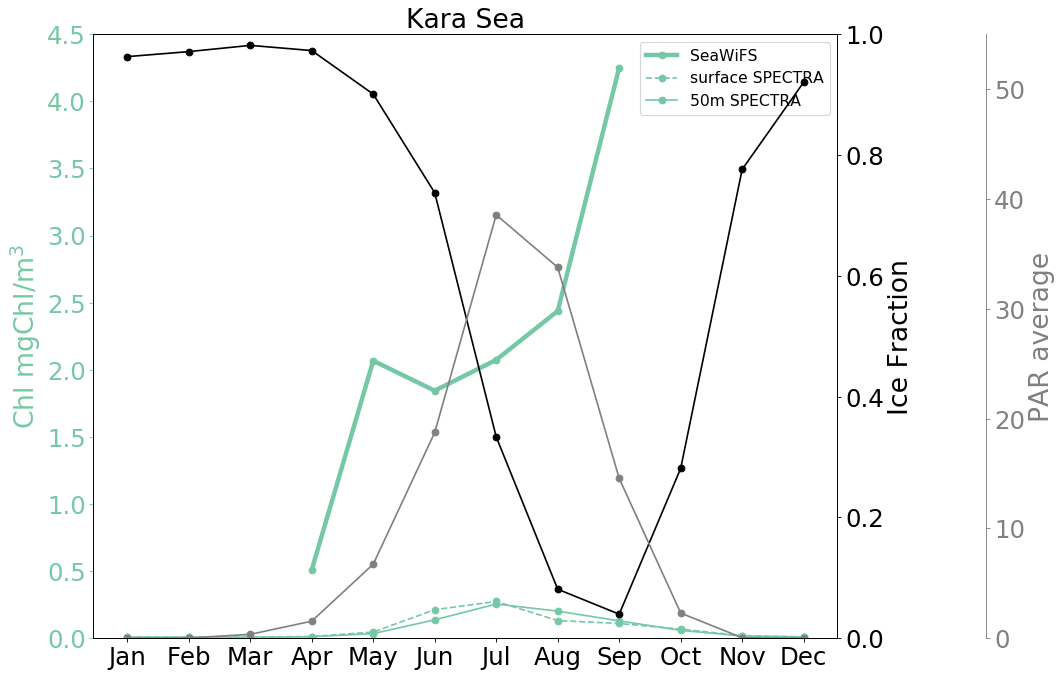

In [41]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ks, '-o', color=cmap(7),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_ks, '--o', color=cmap(7),label='surface SPECTRA')
ax.plot(months,model_ks_50m, '-o', color=cmap(7),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Kara Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ks,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ks,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,4.5); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(7))  
ax.spines['left'].set_color(cmap(7)); ax.tick_params(axis='y', colors=cmap(7))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Kara_Sea_Ice_Fraction_'+year+'year.png', dpi=600, bbox_inches='tight')

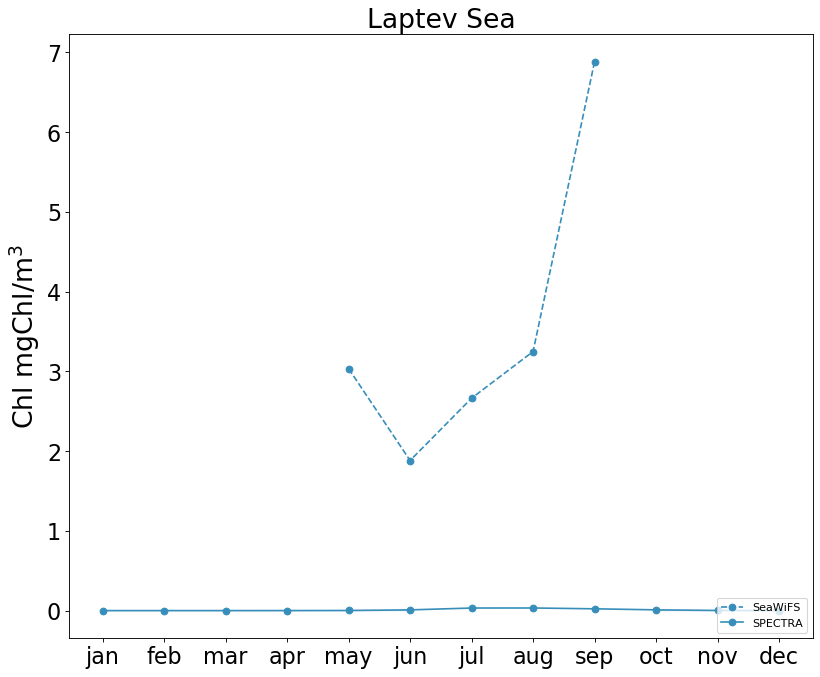

In [44]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ls, '--o', color=cmap(8),label='SeaWiFS')
ax.plot(months,model_ls, '-o', color=cmap(8),label='SPECTRA')
ax.fill_between(months, model_ls, where=np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,270:325],axis=(1,2)) > 0.6, color=cmap(8), alpha=.2)


ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Laptev Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Laptev_Sea_Ice_06_'+year+'year.png', dpi=600, bbox_inches='tight')

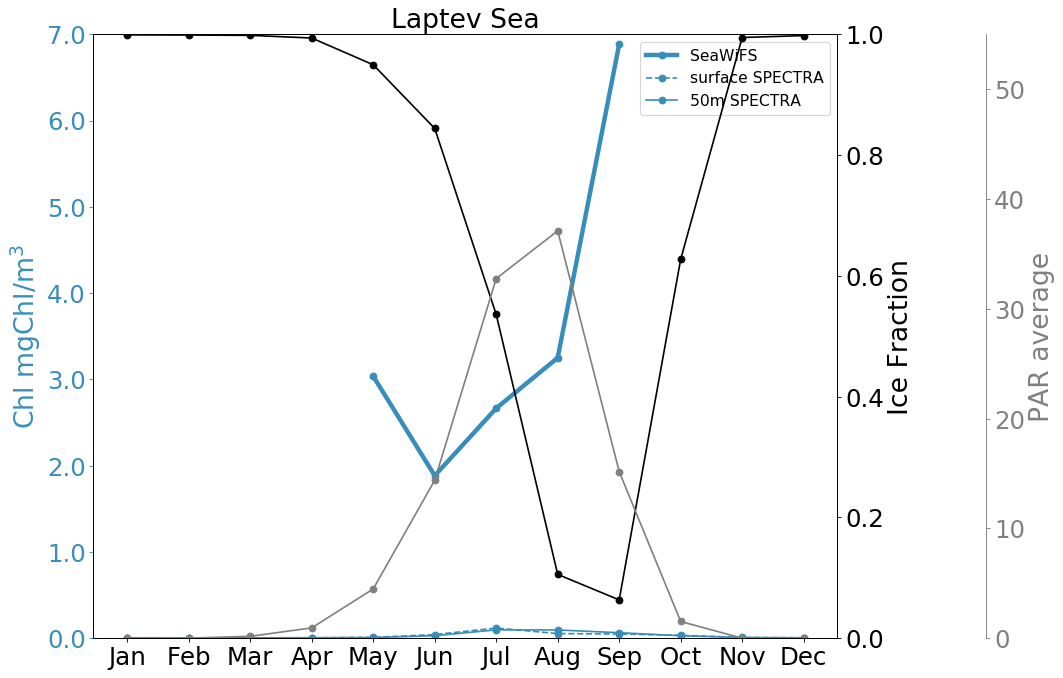

In [42]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ls, '-o', color=cmap(8),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_ls, '--o', color=cmap(8),label='surface SPECTRA')
ax.plot(months,model_ls_50m, '-o', color=cmap(8),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Laptev Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ls,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ls,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,7.0); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(8))  
ax.spines['left'].set_color(cmap(8)); ax.tick_params(axis='y', colors=cmap(8))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Laptev_Sea_Ice_Fraction_'+year+'year.png', dpi=600, bbox_inches='tight')

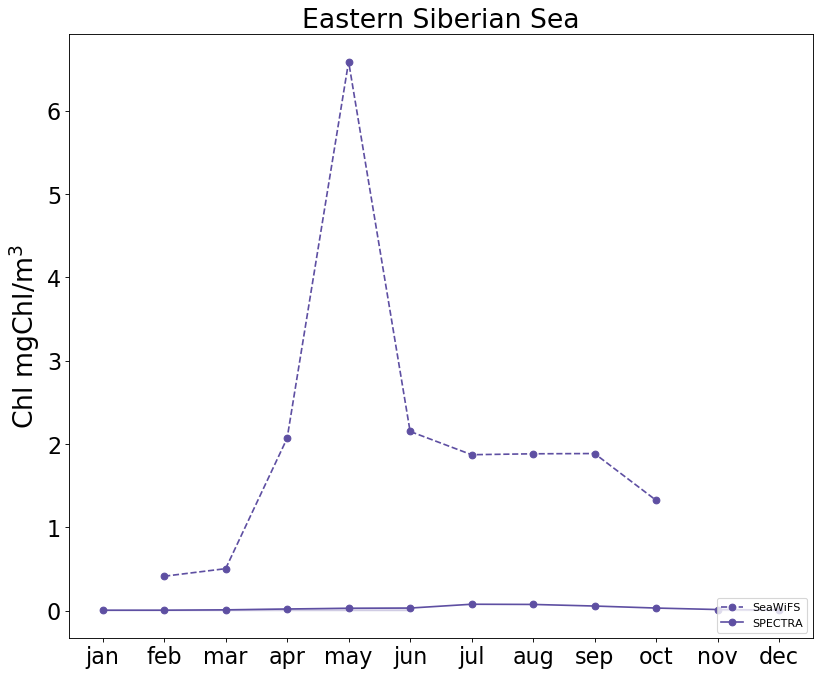

In [46]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ess, '--o', color=cmap(9),label='SeaWiFS')
ax.plot(months,model_ess, '-o', color=cmap(9),label='SPECTRA')
ax.fill_between(months, model_ess, where=np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,325:360],axis=(1,2)) > 0.6, color=cmap(9), alpha=.2)

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Eastern Siberian Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_ESS_Ice_06_'+year+'year.png', dpi=600, bbox_inches='tight')

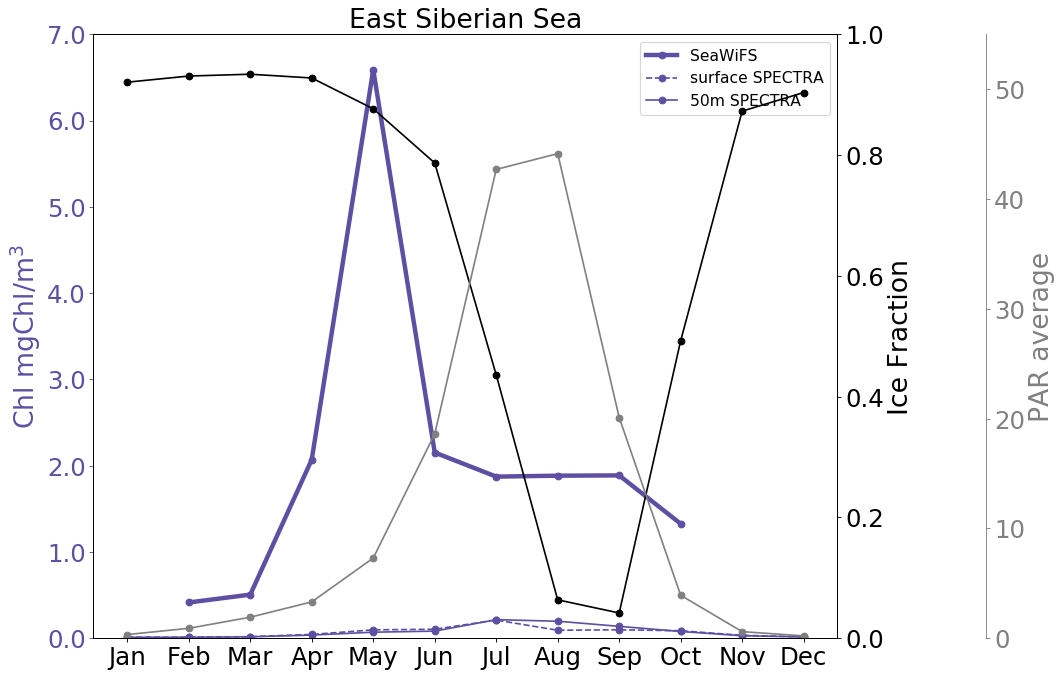

In [43]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ess, '-o', color=cmap(9),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_ess, '--o', color=cmap(9),label='surface SPECTRA')
ax.plot(months,model_ess_50m, '-o', color=cmap(9),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('East Siberian Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ess,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ess,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,7.0); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(9))  
ax.spines['left'].set_color(cmap(9)); ax.tick_params(axis='y', colors=cmap(9))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_East_Siberian_Sea_Ice_Fraction_'+year+'year.png', dpi=600, bbox_inches='tight')